# Setup

## Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import dtale

## Load Data

In [2]:
df_task = pd.read_csv('../../3_3_2_processed_data/run1_tasks.csv')
df_affect = pd.read_csv('../../3_3_2_processed_data/run1_affect.csv')
df_sr = pd.read_csv('../../3_3_2_processed_data/run1_selfReport.csv')

### Merge

In [3]:
df = df_task.merge(df_affect, how='left', on=['ParticipantIdentifier', 'trial_date'])
df = df.merge(df_sr, how='left', on=['ParticipantIdentifier', 'trial_date'])

In [4]:
df.shape

(4276, 159)

### Clean

In [5]:
good_subjects = pd.DataFrame(df.groupby('ParticipantIdentifier')['trial_date'].count()).reset_index()

In [6]:
good_subjects = list(good_subjects.loc[good_subjects.trial_date>=42].ParticipantIdentifier)
print(f'There are {len(good_subjects)} subjects with more than 50% adherence')

There are 46 subjects with more than 50% adherence


In [7]:
df = df.loc[df.ParticipantIdentifier.isin(good_subjects)]

# Explore

## D-Tale

In [ ]:
df.ParticipantIdentifier

In [13]:
d = dtale.show(df)

/Users/djw/opt/miniconda3/envs/battery/lib/python3.9/site-packages/dtale/views.py:725: FutureWarning:

['task_gng_time', 'task_nback_time', 'task_nback_mode', 'task_spatialSpan_time', 'DAILY_past24_gapCause', 'DAILY_past48to24_gapCause', 'DAILY_survey_missed', 'DAILY_survey_situation1_surveys'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



In [14]:
d

Executing shutdown due to inactivity...
Executing shutdown due to inactivity...


2023-01-23 20:58:30,328 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...
Executing shutdown...


2023-01-23 20:58:30,398 - INFO     - Executing shutdown...
/Users/djw/opt/miniconda3/envs/battery/lib/python3.9/site-packages/dtale/app.py:422: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



# Tasks

## EmoStroop

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [8]:
len(np.unique(df.ParticipantIdentifier))

46

In [75]:
cols = ['ParticipantIdentifier', 'trial_date'] + list(df.filter(like='emoStroop').columns)
emoStroop_df = df.loc[:, cols]
emoStroop_df.head(3)

,ParticipantIdentifier,trial_date,task_emoStroop_accuracy_incongruent,task_emoStroop_accuracy_congruent,task_emoStroop_rt_incongruent,task_emoStroop_rt_congruent
1,a33e1d38-6ee8-4da6-993b-a94a8ae7fc30,2022-10-24,1.000000,1.0,2660.714286,1663.0
2,c2097f36-4ca3-4537-856d-a649d1557553,2022-10-24,1.000000,1.0,2452.846154,2203.5
3,bf670311-c590-473a-98ab-d719ebf0f2ab,2022-10-24,0.909091,1.0,1443.000000,1422.5


In [76]:
emoStroop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3319 entries, 1 to 4274
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ParticipantIdentifier                3319 non-null   object 
 1   trial_date                           3319 non-null   object 
 2   task_emoStroop_accuracy_incongruent  3226 non-null   float64
 3   task_emoStroop_accuracy_congruent    3217 non-null   float64
 4   task_emoStroop_rt_incongruent        3226 non-null   float64
 5   task_emoStroop_rt_congruent          3217 non-null   float64
dtypes: float64(4), object(2)
memory usage: 181.5+ KB


In [77]:
emoStroop_df.describe()

,task_emoStroop_accuracy_incongruent,task_emoStroop_accuracy_congruent,task_emoStroop_rt_incongruent,task_emoStroop_rt_congruent
count,3226.000000,3217.000000,3226.000000,3.217000e+03
mean,0.883439,0.937345,2842.395205,3.341755e+03
std,0.172557,0.155553,10869.506794,5.204734e+04
min,0.000000,0.000000,57.166667,9.225000e+01
25%,0.833333,1.000000,1368.893939,1.214000e+03
50%,0.916667,1.000000,1710.954545,1.509667e+03
75%,1.000000,1.000000,2441.644886,2.084500e+03
max,1.000000,1.000000,475763.500000,2.928034e+06


### Remove NAs

In [78]:
emoStroop_df.isna().sum()

ParticipantIdentifier                    0
trial_date                               0
task_emoStroop_accuracy_incongruent     93
task_emoStroop_accuracy_congruent      102
task_emoStroop_rt_incongruent           93
task_emoStroop_rt_congruent            102
dtype: int64

In [79]:
emoStroop_df = emoStroop_df.dropna().reset_index(drop=True)

### Look at Variable Distribution

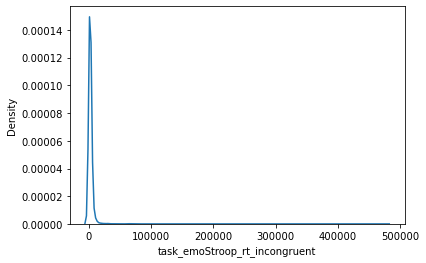

In [80]:
sns.kdeplot(data=emoStroop_df, x="task_emoStroop_rt_incongruent");

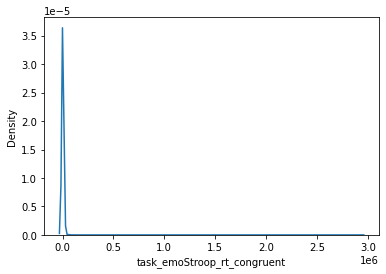

In [81]:
sns.kdeplot(data=emoStroop_df, x="task_emoStroop_rt_congruent");

### Remove Outliers

Using IQR method since right skewed

In [82]:
iqr_n = 1.5

q3, q1 = np.percentile(emoStroop_df.task_emoStroop_rt_congruent, [75, 25])
iqr = q3 - q1
upper_bound_c = q3 + iqr_n * iqr
lower_bound_c = q1 - iqr_n * iqr

In [83]:
iqr

870.5

In [84]:
upper_bound_c

3390.25

In [85]:
q3, q1 = np.percentile(emoStroop_df.task_emoStroop_rt_incongruent, [75, 25])
iqr = q3 - q1
upper_bound_ic = q3 + iqr_n * iqr
lower_bound_ic = q1 - iqr_n * iqr

In [86]:
emoStroop_df = emoStroop_df.loc[(emoStroop_df.task_emoStroop_rt_congruent < upper_bound_c) &
                                (emoStroop_df.task_emoStroop_rt_congruent > lower_bound_c)
                               ]

emoStroop_df = emoStroop_df.loc[(emoStroop_df.task_emoStroop_rt_incongruent < upper_bound_ic) &
                                (emoStroop_df.task_emoStroop_rt_incongruent > lower_bound_ic)
                               ].reset_index(drop=True)

In [88]:
from scipy.stats import ttest_ind
t_val, p_val = ttest_ind(emoStroop_df.task_emoStroop_rt_incongruent, emoStroop_df.task_emoStroop_rt_congruent)
print("ttest_ind: t=%g p-value/2 =%g" % (t_val, p_val/2))

from scipy.stats import ttest_rel
t_val, p_val = ttest_rel(emoStroop_df.task_emoStroop_rt_incongruent, emoStroop_df.task_emoStroop_rt_congruent)
print("ttest_rel: t=%g p-value = %g p-value/2 =%g" % (t_val, p_val, p_val/2))

ttest_ind: t=14.1367 p-value/2 =6.90084e-45
ttest_rel: t=21.7838 p-value = 4.22352e-97 p-value/2 =2.11176e-97


In [89]:
emoStroop_df_long = pd.melt(emoStroop_df, id_vars=['ParticipantIdentifier', 'trial_date'], value_vars=['task_emoStroop_rt_incongruent', 'task_emoStroop_rt_congruent'])

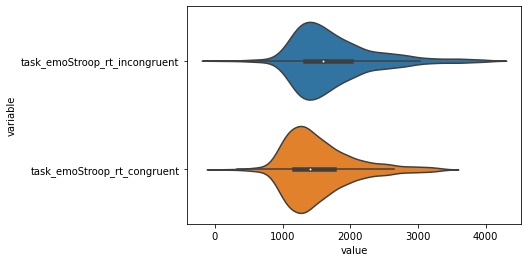

In [92]:
sns.violinplot(data=emoStroop_df_long, x="value", y="variable");

In [93]:
emoStroop_df.describe()

,task_emoStroop_accuracy_incongruent,task_emoStroop_accuracy_congruent,task_emoStroop_rt_incongruent,task_emoStroop_rt_congruent
count,2718.000000,2718.000000,2718.000000,2718.000000
mean,0.886985,0.937416,1747.247918,1530.214386
std,0.169233,0.156217,611.723409,516.159723
min,0.000000,0.000000,57.166667,92.250000
25%,0.846154,1.000000,1324.415385,1171.273810
50%,0.923077,1.000000,1590.909091,1408.733333
75%,1.000000,1.000000,2011.493056,1762.087500
max,1.000000,1.000000,4050.750000,3381.750000
